In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset (assuming the DataFrame 'df' is already loaded with 'tweet' and 'label' columns)
df = pd.read_csv("../data/mendeley_data/HateSpeechDatasetBalanced.csv")
tweets = df['Content'].values
labels = df['Label'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

# Load the saved BiLSTM model
model_bilstm = load_model('bilstm_model.h5')

# Unfreeze the last 2 layers
for layer in model_bilstm.layers[:-2]:
    layer.trainable = False


In [6]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(tweets)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post', truncating='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post', truncating='post')


In [7]:
# Compile the model with a smaller learning rate
model_bilstm.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the BiLSTM model
history_bilstm_fine_tune = model_bilstm.fit(X_train_seq, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Save the fine-tuned BiLSTM model
model_bilstm.save('bilstm_model_fine_tuned.h5')
print('Fine-tuned BiLSTM model saved as bilstm_model_fine_tuned.h5')

Epoch 1/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 535s 147ms/step - accuracy: 0.9104 - loss: 0.2148 - val_accuracy: 0.8638 - val_loss: 0.3208
Epoch 2/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 547s 151ms/step - accuracy: 0.9106 - loss: 0.2125 - val_accuracy: 0.8637 - val_loss: 0.3250
Epoch 3/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 575s 158ms/step - accuracy: 0.9111 - loss: 0.2109 - val_accuracy: 0.8636 - val_loss: 0.3280
Epoch 4/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 588s 162ms/step - accuracy: 0.9106 - loss: 0.2111 - val_accuracy: 0.8637 - val_loss: 0.3300
Epoch 5/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 604s 166ms/step - accuracy: 0.9114 - loss: 0.2106 - val_accuracy: 0.8637 - val_loss: 0.3315
Epoch 6/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 617s 170ms/step - accuracy: 0.9110 - loss: 0.2111 - val_accuracy: 0.8637 - val_loss: 0.3324
Epoch 7/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 629s 173ms/step - accuracy: 0.9110 - loss: 0.2111 - val_accuracy: 0.8637 - val_loss: 0.3331
Epoch 8/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 671s 185ms/step - ac

Fine-tuned BiLSTM model saved as bilstm_model_fine_tuned.h5


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

def evaluate_model(model_bilstm, X_test, y_test, model_type='sequential', attention_masks=None):
    if model_type == 'bert':
        y_pred_prob = model_bilstm.predict([X_test, attention_masks])
    else:
        y_pred_prob = model_bilstm.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return cm, precision, recall, f1

In [13]:
# Evaluate BiLSTM model
cm_bilstm, precision_bilstm, recall_bilstm, f1_bilstm = evaluate_model(model_bilstm, X_test_seq, y_test)



4539/4539 ━━━━━━━━━━━━━━━━━━━━ 280s 61ms/step


TF-IDF

In [10]:

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=2000)  # Reduced from 5000 to 2000
X_tfidf = vectorizer.fit_transform(tweets).toarray().astype('float32')

# Split the data
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)


In [11]:
model_tfidf = load_model('tfidf_model.h5')

# Unfreeze the last 2 layers
for layer in model_tfidf.layers[:-2]:
    layer.trainable = False

# Compile the model with a smaller learning rate
model_tfidf.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the TF-IDF model
history_tfidf_fine_tune = model_tfidf.fit(X_train_tfidf, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Save the fine-tuned TF-IDF model
model_tfidf.save('tfidf_model_fine_tuned.h5')
print('Fine-tuned TF-IDF model saved as tfidf_model_fine_tuned.h5')

Epoch 1/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.6948 - loss: 0.9154 - val_accuracy: 0.6946 - val_loss: 0.6967
Epoch 2/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6910 - loss: 0.6890 - val_accuracy: 0.6849 - val_loss: 0.5948
Epoch 3/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.6825 - loss: 0.6096 - val_accuracy: 0.6821 - val_loss: 0.5831
Epoch 4/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.6783 - loss: 0.6010 - val_accuracy: 0.6847 - val_loss: 0.5790
Epoch 5/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.6836 - loss: 0.5930 - val_accuracy: 0.6869 - val_loss: 0.5760
Epoch 6/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6829 - loss: 0.5908 - val_accuracy: 0.6900 - val_loss: 0.5740
Epoch 7/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.6891 - loss: 0.5843 - val_accuracy: 0.6928 - val_loss: 0.5725
Epoch 8/10
3631/3631 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6898 - loss: 

Fine-tuned TF-IDF model saved as tfidf_model_fine_tuned.h5


In [14]:
# Evaluate TF-IDF Neural Network model
cm_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = evaluate_model(model_tfidf, X_test_tfidf, y_test)


4539/4539 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step


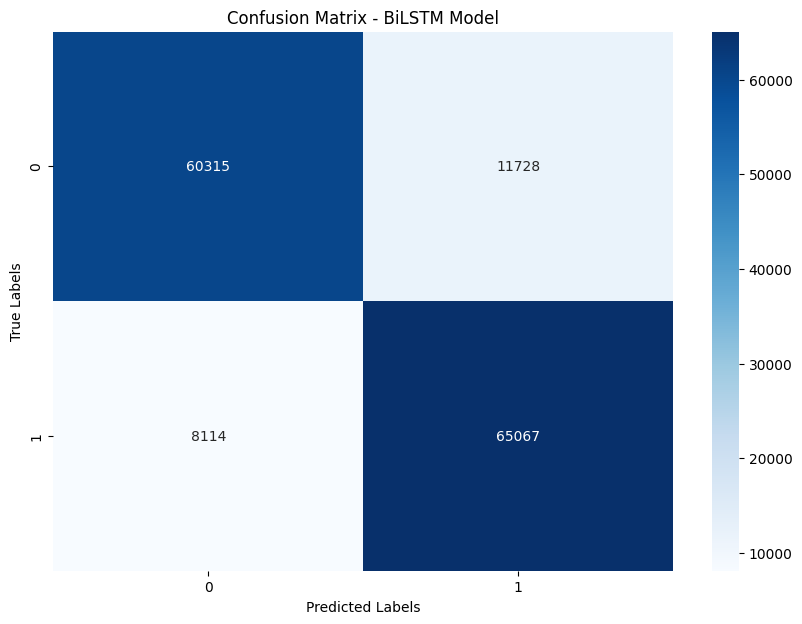

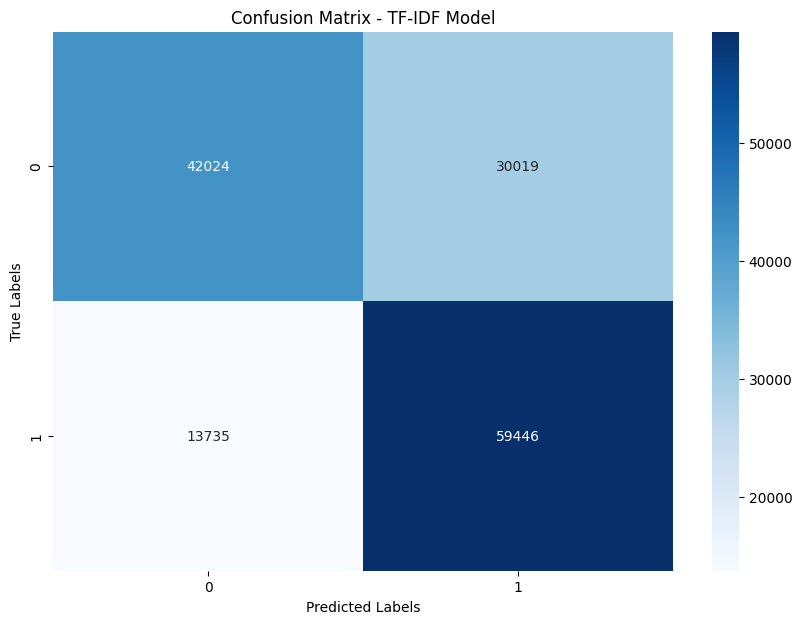

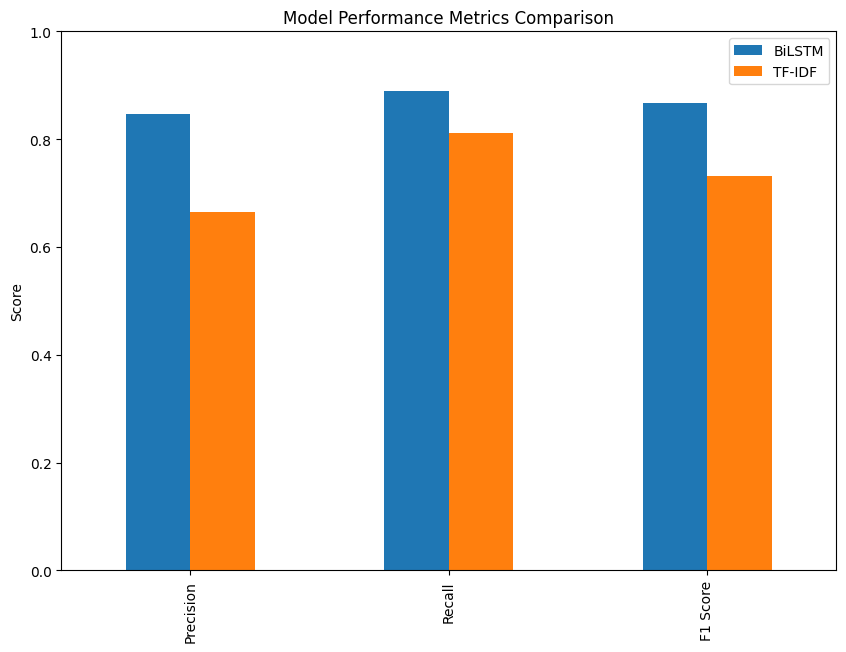

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(cm_bilstm, 'Confusion Matrix - BiLSTM Model')
plot_confusion_matrix(cm_tfidf, 'Confusion Matrix - TF-IDF Model')


# Plotting precision, recall, and F1 score
metrics = {
    'BiLSTM': [precision_bilstm, recall_bilstm, f1_bilstm],
    'TF-IDF': [precision_tfidf, recall_tfidf, f1_tfidf],
}

metrics_df = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F1 Score'])

metrics_df.plot(kind='bar', figsize=(10, 7))
plt.ylim(0, 1)
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.show()
